# The MNIST dataset

## Load all modules

In [65]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Get the data

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)

## Inspect the data

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

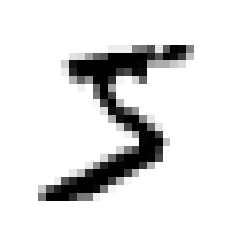

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [9]:
y[0]

5

## Split the data into training and test sets

Note: the MNIST dataset is already split and shuffled, so we just extract the corresponding entries

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## A binary classifier: Stochastic Gradient Descent (SGD)

We first consider only a subclass where the label is '5' and train a binary classifier on it, i.e. 'true' if '5' and else otherwise.

### Get the data

We convert the labels into a binary form.

In [11]:
y_train_5, y_test_5 = (y_train == 5), (y_test == 5)

### Train the model

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

### Evaluate the accuracy with cross-validation

In [14]:
# Own version of cross-validation which can be modified according to our needs.
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    accuracy = n_correct/len(y_pred)
    print(accuracy)

0.95035
0.96035
0.9604


In [15]:
# Cross-validation evaluation
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

The accuracy seems already pretty high. But note the following:

In [16]:
class naiveValidator(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
sgd_clf_naive = naiveValidator()
cross_val_score(sgd_clf_naive, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This 'naive' classifier just produces a list of the same length as X_train with exclusively 'False' entries. Since the dataset X_train contains a roughly equal amount of images labeled from 0 to 9 and we train a boolean classifier (either it's a 5 or not), we achieve roughly 9/10 = 90% accuracy by just performing the validation with the array with exclusively 'False' entries.

### Evaluation with a confusion matrix

In [17]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
print(conf_matrix)

[[53892   687]
 [ 1891  3530]]


### Precision, recall, specificity, fall-out and the F1 score

**Precision**, i.e. accuracy of the positive predictions:<br>$\frac{\text{TP}}{\text{TP} + \text{FP}}$

In [19]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[0][1])

0.8370879772350012

**Recall**, i.e. **sensitivity** or true positive rate (TPR), i.e. ratio of positives that are correctly identified:<br>$\frac{\text{TP}}{\text{TP} + \text{FN}}$

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[1][0])

0.6511713705958311

**Specificity**, i.e. true negative rate (TNR), i.e. ratio of negatives that are correctly identified:<br>$\frac{\text{TN}}{\text{TN} + \text{FP}}$

In [23]:
conf_matrix[0][0]/(conf_matrix[0][0] + conf_matrix[0][1])

0.987412741164184

**Fall-out**, i.e. false positive rate (FPR), i.e. probability of falsely rejecting the null hypothesis, i.e. ratio of negative instances incorrectly classified as positive:<br>$\frac{\text{FP}}{\text{TN} + \text{FP}} = 1 - \text{TNR}$

In [24]:
conf_matrix[0][1]/(conf_matrix[0][0] + conf_matrix[0][1])

0.012587258835815972

**F1 score**, i.e. the harmonic mean of precision and recall:<br>$\frac{2}{\frac{1}{\text{recall}} + \frac{1}{\text{precision}}}$

In [25]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/recall trade-off

Get the scores of the classifier for the training set:

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

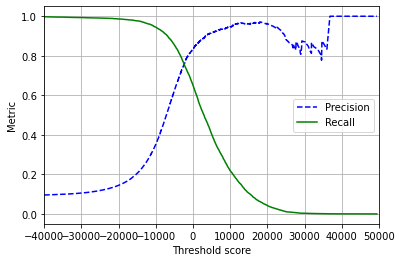

In [28]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlim(-40000, 50000)
plt.grid()
plt.xlabel('Threshold score')
plt.ylabel('Metric')
plt.legend()
plt.show()

### The Precision Recall (PR) curve

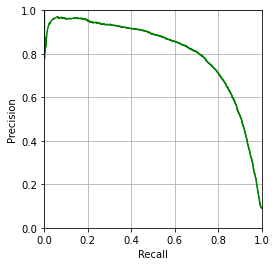

In [29]:
plt.clf()
plt.plot(recalls[:-1], precisions[:-1], 'g-', label='Precision/Recall')
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Let's say we want a classifier with 90% precision:

In [30]:
treshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [31]:
y_train_pred_90 = y_scores >= treshold_90_precision

Precision is indeed roughly 90% ...

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

... but the recall is rather low:

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The Receiver Operating Characteristic (ROC) curve

The ROC curve is gained by plotting recall (TPR) against the false positive rate (FPR), i.e. plotting sensitivity against 1-specificity:

In [34]:
fpr, tpr, thresholds2 = roc_curve(y_train_5, y_scores)

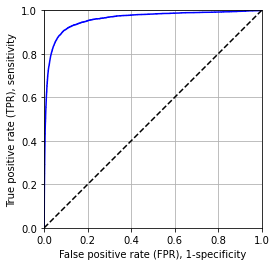

In [35]:
plt.clf()
plt.plot(fpr, tpr, 'b-', label='TPR/FPR')
plt.plot(fpr, fpr, 'k--', label='Random')
plt.grid()
plt.xlabel('False positive rate (FPR), 1-specificity')
plt.ylabel('True positive rate (TPR), sensitivity')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The dashed line indicates the ROC plot of a purely random classifier. A good classifier typically aims for high sensitivity and specificity (or equivalently, low FPR), i.e. the classifier should aim for the top-left corner.

### The ROC area under curve (AUC) score

The ROC AUC score is given as the area under the ROC curve. A random classifier has a ROC AUC score of 0.5 while a perfect classifier has a ROC AUC score of 1.0.

In [36]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

The ROC AUC score is rather high, which indicates a good classifier, or not? More on that below.

### PR curve vs. ROC curve - when to use which

Use the PR curve, if
 - the positive class is rare
 - the false positives are more relevant than the false negatives

Otherwise, use the ROC curve.

### PR and ROC for our example

While the ROC AUC score is pretty high, we note that the positive class is rare in our case (roughly 1/10 against 9/10 of the samples), so we should pay more attention to the PR curve which, as we have seen above, is not ideal.

## A Random Forest Classifier for the binary classification of 5s and non-5s

In [37]:
forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [38]:
y_probas_forest

array([[0.12, 0.88],
       [0.99, 0.01],
       [0.95, 0.05],
       ...,
       [0.  , 1.  ],
       [0.9 , 0.1 ],
       [0.93, 0.07]])

In [39]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

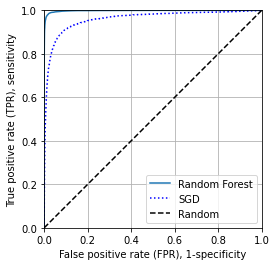

In [40]:
plt.clf()
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr, fpr, 'k--', label='Random')
plt.grid()
plt.xlabel('False positive rate (FPR), 1-specificity')
plt.ylabel('True positive rate (TPR), sensitivity')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

### The ROC AUC

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.99825976206211

### Recall

In [42]:
y_scores_forest_conv = np.array([True if x>0.5 else False for x in y_scores_forest])
recall_score(y_train_5, y_scores_forest_conv)

0.8693967902600996

### Precision

In [43]:
precision_score(y_train_5, y_scores_forest_conv)

0.9884647651006712

### Comparison of the Random Forest Classifier with the SGD Classifier

As can be seen by the ROC curve, the ROC AUC and the values for recall and precision, the random forest performs **significantly** better than the SGD.



## Multiclass Classification

### Automatic one-versus-one (OvO) stragety

Scikit-learn automatically chooses a OvO or one-versus-rest (OvR) strategy when we use a multiclass dataset with a binary classifier, e.g. a support vector classifier (SVC):

In [45]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In this case, the classifier gives one score for each class:

In [46]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The class with the highest score is chosen as the prediction:

In [47]:
np.argmax(some_digit_scores)

5

In [48]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [49]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

### Explicitly choosing OvO or OvR strategies

Explicitly choose an OvR strategy:

In [53]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

### Training a SGD classifier with multiple classes

Many classifiers are directly compatible with multiple classes:

In [54]:
sgd_clf_multi = SGDClassifier(random_state=42)
sgd_clf_multi.fit(X_train, y_train)
sgd_clf_multi.predict([some_digit])

array([3], dtype=uint8)

In these cases, the classifier yields one score per class and instance:

In [55]:
sgd_clf_multi.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

### Cross-validating the SGD classifier

In [56]:
cross_val_score(sgd_clf_multi, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

### Improve the accuracy by scaling the inputs

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf_multi, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error analysis

### Check the confusion matrix

In [59]:
y_train_pred = cross_val_predict(sgd_clf_multi, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

<Figure size 432x288 with 0 Axes>

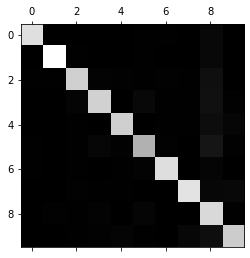

In [60]:
plt.clf()
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

### Normalize the confusion matrix to the error ratios

Per default, the confusion matrix shows absolute errors which might be misleading if the dataset is skewed towards some classes. Hence, we calculate the error ratios and show them instead.

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal entries with zeroes since we focus on the errors only.

In [63]:
np.fill_diagonal(norm_conf_mx, 0)

Show the modified confusion matrix:

<Figure size 432x288 with 0 Axes>

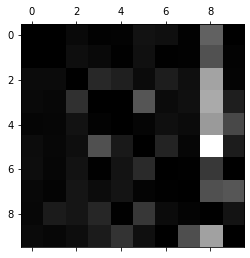

In [64]:
plt.clf()
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

From this, we can deduce the types of errors that our classifier makes:<br>A significant amount of numbers are wrongly classified as being an '8', while the actual '8's are often correctly classified. Additionally, quite a few numbers are wrongly classified as being a '9'.

## Multilabel classification

### Training

Some classifiers support multiple labels as the targets, e.g. the k-nearest neighbors (KNN) classifier.

In [66]:
y_large = (y_train >= 7)
y_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_large, y_odd]

In [67]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

### Evaluation

One possible way of evaluation is by calculating the metric (e.g. F1 score) for each class individually and then taking the average of the achieved scores.

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [70]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

Caveat: by choosing the 'macro' average, we assume that each class has roughly the same significance. If one class is represented more frequently than another, it is often better to use the 'weighted' average:

In [71]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

## Multioutput classification

It is possible that each output label can have a range of values. In this case, we have a multioutput classifier, i.e. a generalization of the multilabel classifier. As an example, we consider images with artificially added noise as the input and the noise-free original images as the targets. The multioutput classifier will produce arrays as outputs, with each entry of the array being a number from 0 to 255 (i.e. the pixel's grayscale value).

In [72]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

This is one of the original images:

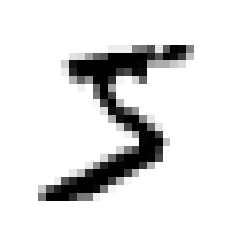

In [84]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

This is one of the images with some noise added:

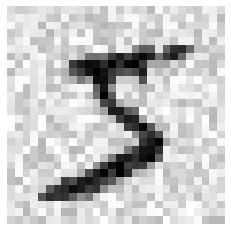

In [85]:
some_digit_mod = X_train_mod[0]
some_digit_image_mod = some_digit_mod.reshape(28, 28)

plt.imshow(some_digit_image_mod, cmap='binary')
plt.axis('off')
plt.show()

In [82]:
knn_clf_mod = KNeighborsClassifier()
knn_clf_mod.fit(X_train_mod, y_train_mod)
cleansed_digit = knn_clf_mod.predict([some_digit_mod])

This is the cleansed image, gained through the classifier:

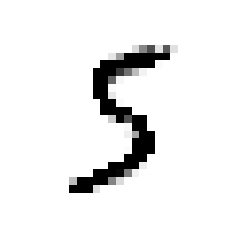

In [83]:
plt.imshow(list(cleansed_digit)[0].reshape(28, 28), cmap='binary')
plt.axis('off')
plt.show()